In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import edward2 as ed
import warnings

from observations import iris, mnist
DATA_DIR = './data'

plt.style.use("ggplot")
warnings.filterwarnings('ignore')

print('Tensorflow Probability version: ', tf.__version__)

/opt/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import regi

Tensorflow Probability version:  1.10.0-dev20180716


In [5]:
# (x_train, y_train), (x_test, y_test) = mnist(DATA_DIR)
(x_test, y_test), (x_train, y_train) = mnist(DATA_DIR)
x_train = x_train.T
print(x_train.shape, y_train.shape)
print(y_train[:10])

(784, 10000) (10000,)
[7 2 1 0 4 1 4 9 5 9]


In [4]:
x_train, y_train, metadata = iris(DATA_DIR)

# standardize data
# x_mean = np.mean(x_train, axis=0)
# x_std = np.std(x_train, axis=0)
# x_train = (x_train - x_mean) / x_std

x_train = x_train.T
print(x_train.shape, y_train.shape)
print(metadata)

y_label = np.unique(y_train)
y_dict = dict((label, i) for i, label in enumerate(y_label))
y_class = list(map(lambda label: y_dict[label], y_train))


(4, 150) (150,)
{'columns': ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']}


+ Marginal distribution of each data point:**

\begin{equation*}
\mathbf{x}_n \sim \mathcal{N}(\mathbf{0}, \mathbf{W} \mathbf{W}^T + \sigma^2 \mathbf{I})
\end{equation*}

+ Create a model as follow:
    * $\mathbf{z}_n \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$
    * $\mathbf{W} \sim \mathcal{N}(\mathbf{0}, 2 \mathbf{I})$
    * $\mathbf{x}_n | \mathbf{z}_n \sim \mathcal{N}(
        \mathbf{W} \mathbf{z}_n, \sigma^2 \mathbf{T} 
      )$


In [6]:
def ppca_model(data_dim, latent_dim, num_datapoints, stddev_datapoints):
    w = ed.Normal(loc=tf.zeros([data_dim, latent_dim]),
                  scale=tf.ones([data_dim, latent_dim]),
                  name="w") # parameter
    z = ed.Normal(loc=tf.zeros([latent_dim, num_datapoints]),
                  scale=tf.ones([latent_dim, num_datapoints]),
                  name="z") # parameter
    x = ed.Normal(loc=tf.matmul(w, z),
                  scale=stddev_datapoints * tf.ones([data_dim, num_datapoints]),
                  name="x") # modeled (observed) data
    return x, (w, z)

log_joint = ed.make_log_joint_fn(ppca_model)

### GENERATE DATASET

In [7]:
num_datapoints = x_train.shape[1]
data_dim = x_train.shape[0]
latent_dim = 2
stddev_datapoints = 0.5

# model = ppca_model(data_dim=data_dim,
#                    latent_dim=latent_dim,
#                    num_datapoints=num_datapoints,
#                    stddev_datapoints=stddev_datapoints)

# with tf.Session() as sess:
#     x_train, (actual_w, actual_z) = sess.run(model)
    
# print("Principal axes: ")
# print(actual_w)
print(num_datapoints, data_dim, latent_dim)

10000 784 2


In [ ]:
plt.scatter(x_train[0,:], x_train[1,:], color='blue', alpha=0.1)
plt.axis([-10, 10, -10, 10])
plt.title("Original Dataset")
plt.show()

### MAP: Maximum A Posterior Inference

+ **Goal**: find the point estimate of laten variables that maximizes the posterior probability density (maximum a posterior inference).
+ **Note**: The point-estimate methods find the exact values for each latent var. The variational methods find the probability distribution of the value of each latent var.
+ **How**: Calculating the values of $\mathbf{W}$ and $\mathbf{Z}$ that maxmize the posterior density: $p(\mathbf{W}, \mathbf{Z} | \mathbf{X})\propto p(\mathbf{W}, \mathbf{Z}, \mathbf{X})$.
Note that the `log_joint` function created by `ed.make_log_joint_fn` will represent for the log of the joint distribution of all variables in the model.

In [ ]:
# what we actually want to find is `w` and `z`
# we have had their asumption "prior" values.
# we need to use the observed data `x` to do inference:
# that means, to transfer the prior to the posterior
# and the final expected results will be in `w_inferred_map` and `z_inferred_map`

In [8]:
# first, define `w` and `z` as variable in the model

tf.reset_default_graph()

w = tf.Variable(np.ones([data_dim, latent_dim]), dtype=tf.float32)
z = tf.Variable(np.ones([latent_dim, num_datapoints]), dtype=tf.float32)

In [9]:
# second, define a target function, which is an "unnormalized target density".
# as a function of the parameters `w`, `z`
# Note that we want to maximize the posterior distr.
# which is proportional to the joint distribution of the model
# -> the target function to maximize is exactly the joint distr. function
def target(w, z):
    return log_joint(data_dim=data_dim,
              latent_dim=latent_dim,
              num_datapoints=num_datapoints,
              stddev_datapoints=stddev_datapoints,
              w=w, z=z, x=x_train)

In [10]:
# third, define the "energy function", which is the opposite of target function
# we will use the off-the-shelf optimization module which minimize an objective function
# that's why we conver the maximization prob. to mizimization one
energy = - target(w, z)

optimizer = tf.train.AdamOptimizer(learning_rate=0.05)
train = optimizer.minimize(energy)

In [17]:
# Learning params === Infering

init = tf.global_variables_initializer()

t = []

num_epochs = 500

with tf.Session() as sess:
    # init all variables
    sess.run(init)
    
    # start to train
    for i in range(num_epochs):
        sess.run(train)
                
        if i % 10 == 0:
            # get snapshot of the current values of function and vars
            cE, cw, cz = sess.run([energy, w, z])
            print("Loss at epoch {} = {}".format(i,cE))
            t.append(cE)
    
    # when finishing the training, get the learned values of the variables
    w_inferred_map = sess.run(w)
    z_inferred_map = sess.run(z)

Loss at epoch 0 = 113888133120.0
Loss at epoch 10 = 111201165312.0
Loss at epoch 20 = 107653693440.0
Loss at epoch 30 = 103101472768.0
Loss at epoch 40 = 97626677248.0
Loss at epoch 50 = 91828658176.0
Loss at epoch 60 = 85999165440.0
Loss at epoch 70 = 80641753088.0
Loss at epoch 80 = 76095111168.0
Loss at epoch 90 = 72525217792.0
Loss at epoch 100 = 69906407424.0
Loss at epoch 110 = 68096954368.0
Loss at epoch 120 = 66896343040.0
Loss at epoch 130 = 66116091904.0
Loss at epoch 140 = 65610006528.0
Loss at epoch 150 = 65281036288.0
Loss at epoch 160 = 65065246720.0
Loss at epoch 170 = 64922980352.0
Loss at epoch 180 = 64828551168.0
Loss at epoch 190 = 64765550592.0
Loss at epoch 200 = 64723021824.0
Loss at epoch 210 = 64694267904.0
Loss at epoch 220 = 64674672640.0
Loss at epoch 230 = 64661024768.0
Loss at epoch 240 = 64651362304.0
Loss at epoch 250 = 64644878336.0
Loss at epoch 260 = 64640163840.0
Loss at epoch 270 = 64636887040.0
Loss at epoch 280 = 64634527744.0
Loss at epoch 290 = 6

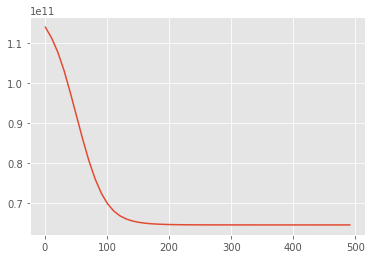

In [18]:
x = range(1, num_epochs, 10)
plt.plot(x, t)
plt.show()

In [19]:
# print("Principal axes: ")
# print(actual_w)

print("MAP estimated axes:")
print(w_inferred_map)

MAP estimated axes:
[[-6.851531e-13 -6.851531e-13]
 [-6.851531e-13 -6.851531e-13]
 [-6.851531e-13 -6.851531e-13]
 ...
 [-6.851531e-13 -6.851531e-13]
 [-6.851531e-13 -6.851531e-13]
 [-6.851531e-13 -6.851531e-13]]


### Model criticism

In [ ]:
# using Edward2 model to sample data from inferred values of W and Z

def replace_latents(w=actual_w, z=actual_z):
    def interceptor(rv_constructor, *rv_args, **rv_kwargs):
        """Replace the prior with actual values to generate samples from."""
        name = rv_kwargs.pop("name")
        if name == "w":
            rv_kwargs["value"] = w
        elif name == "z":
            rv_kwargs["value"] = z
        return rv_constructor(*rv_args, **rv_kwargs)
    
    return interceptor


with ed.interception(replace_latents(w_inferred_map, z_inferred_map)):
    generative_process = ppca_model(
        data_dim=data_dim, latent_dim=latent_dim,
        num_datapoints=num_datapoints, stddev_datapoints=stddev_datapoints
    )
    
with tf.Session() as sess:
    x_generated, _ = sess.run(generative_process)

In [ ]:
# compare the actual data with the simulated data 
# which is generated from the joint model with the MAP estimated `w` and `z`

plt.scatter(x_train[0, :], x_train[1, :], color='blue', alpha=0.1, label='Actual data')
plt.scatter(x_generated[0, :], x_generated[1, :], color='red', alpha=0.1, label='Simulated MAP')
plt.legend()
# plt.axis([-20, 20, -20, 20])
plt.show()

In [ ]:
# plt.scatter(x_train[0, :], x_train[1, :], color='blue', alpha=0.05, label='Actual data')
# plt.plot([-w_inferred_map[0][0], w_inferred_map[0][0]], [-w_inferred_map[1][0], w_inferred_map[1][0]])
# plt.show()

In [ ]:
print(w_inferred_map)

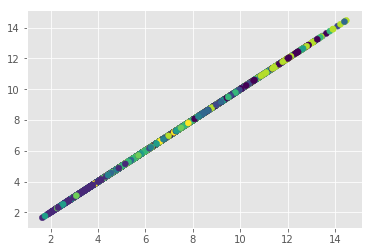

In [20]:
plt.scatter(z_inferred_map[0, :], z_inferred_map[1, :], c=y_train)
# for i in range(data_dim):
#     vx, vy = w_inferred_map[i] / np.linalg.norm(w_inferred_map[i])
#     print(vx, vy)
#     plt.plot([0,vx], [0,vy])
plt.show()